# CS-493D Machine Learning Final Project

*This project uses several machine learning models to gain insights from opioid data available from data.gov.*


I looked at the data set titled "Accidental Drug Related Deaths 2012-June 2017" available at: https://catalog.data.gov/dataset/accidental-drug-related-deaths-january-2012-sept-2015.

In particular, I attempted to answer the following question:
"Given an accidental drug overdose related death, can we accurately predict the drug that was used? i.e. whether the overdose is related Heroin, Cocaine, Fentanyl, Oxycodone, Oxymorphone, EtOH, Hydrocodone, Benzodiazepine, Methadone, Amphet, Tramad, Morphine, or Other kind of drug?"


## Setup 

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [307]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    if not os.path.exists(IMAGES_PATH):
        os.makedirs(IMAGES)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the Data

In [353]:
import io
import requests
import pandas as pd

DOWNLOAD_URL = "https://data.ct.gov/api/views/rybz-nyjw/rows.csv"
DATA_SET_FILE = "Accidental_Drug_Related_Deaths__2012-June_2017.csv"

def fetch_opioid_data():
    s=requests.get(DOWNLOAD_URL).content
    return pd.read_csv(io.StringIO(s.decode('utf-8')))

In [354]:
data = fetch_opioid_data()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3583 entries, 0 to 3582
Data columns (total 32 columns):
CaseNumber               3583 non-null object
Date                     3581 non-null object
Sex                      3580 non-null object
Race                     3573 non-null object
Age                      3581 non-null float64
Residence City           3490 non-null object
Residence State          1663 non-null object
Residence County         2885 non-null object
Death City               3579 non-null object
Death State              1702 non-null object
Death County             2405 non-null object
Location                 3561 non-null object
DescriptionofInjury      998 non-null object
InjuryPlace              3506 non-null object
ImmediateCauseA          3581 non-null object
Heroin                   1936 non-null object
Cocaine                  998 non-null object
Fentanyl                 1114 non-null object
Oxycodone                491 non-null object
Oxymorphone          

## Clean the Data

In [355]:
# Remove all the rows where the age is missing
data.dropna(subset=["Age"])

,CaseNumber,Date,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,...,Benzodiazepine,Methadone,Amphet,Tramad,Morphine (not heroin),Other,Any Opioid,MannerofDeath,AmendedMannerofDeath,DeathLoc
0,13-16336,11/09/2013,Female,White,53.0,GROTON,NaN,NEW LONDON,GROTON,NaN,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"GROTON, CT\n(41.343693, -72.07877)"
1,12-18447,12/29/2012,Male,White,30.0,WOLCOTT,NaN,NEW HAVEN,WATERBURY,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"WATERBURY, CT\n(41.554261, -73.043069)"
2,14-2758,02/18/2014,Male,White,43.0,ENFIELD,NaN,NaN,ENFIELD,NaN,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"ENFIELD, CT\n(41.976501, -72.591985)"
3,14-13497,09/07/2014,Female,White,24.0,WALLINGFORD,NaN,NaN,WALLINGFORD,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"WALLINGFORD, CT\n(41.454408, -72.818414)"
4,13-14421,10/04/2013,Female,White,26.0,WEST HAVEN,NaN,NEW HAVEN,WEST HAVEN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"WEST HAVEN, CT\n(41.272336, -72.949817)"
5,13-18018,12/10/2013,Female,White,45.0,RIDGEFIELD,NaN,FAIRFIELD,DANBURY,NaN,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"DANBURY, CT\n(41.393666, -73.451539)"
6,13-19004,12/27/2013,Male,White,55.0,WEST HAVEN,NaN,NEW HAVEN,BRIDGEPORT,NaN,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,Pending,NaN,"BRIDGEPORT, CT\n(41.179195, -73.189476)"
7,13-3783,03/04/2013,Male,"Hispanic, White",47.0,NEW HAVEN,NaN,NEW HAVEN,NEW HAVEN,NaN,...,NaN,Y,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"NEW HAVEN, CT\n(41.308252, -72.924161)"
8,14-5669,04/09/2014,Female,White,53.0,DANBURY,NaN,NaN,DANBURY,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"DANBURY, CT\n(41.393666, -73.451539)"
9,13-9675,06/28/2013,Male,White,29.0,WATERBURY,NaN,NEW HAVEN,WATERBURY,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"WATERBURY, CT\n(41.554261, -73.043069)"


In [ ]:
data.describe()

In [356]:
"""
The DeathLoc includes the city, state as well as the lattitude (lat) and longitude (lon) values. 
By extracting the lat and lon
"""
import re

data['DeathLoc2'] = data['DeathLoc'].apply( lambda x: re.sub("\s*[A-Za-z()\s]+\s*", "", str(x)) );

data['lat'] = data['DeathLoc2'].apply( lambda x: x.split(',')[1] )
data['lon'] = data['DeathLoc2'].apply( lambda x: x.split(',')[-1] )

,Age
count,3581.000000
mean,41.999721
std,12.337627
min,14.000000
25%,32.000000
50%,43.000000
75%,52.000000
max,87.000000


## Visualize the Data

Saving figure age_histogram_plot


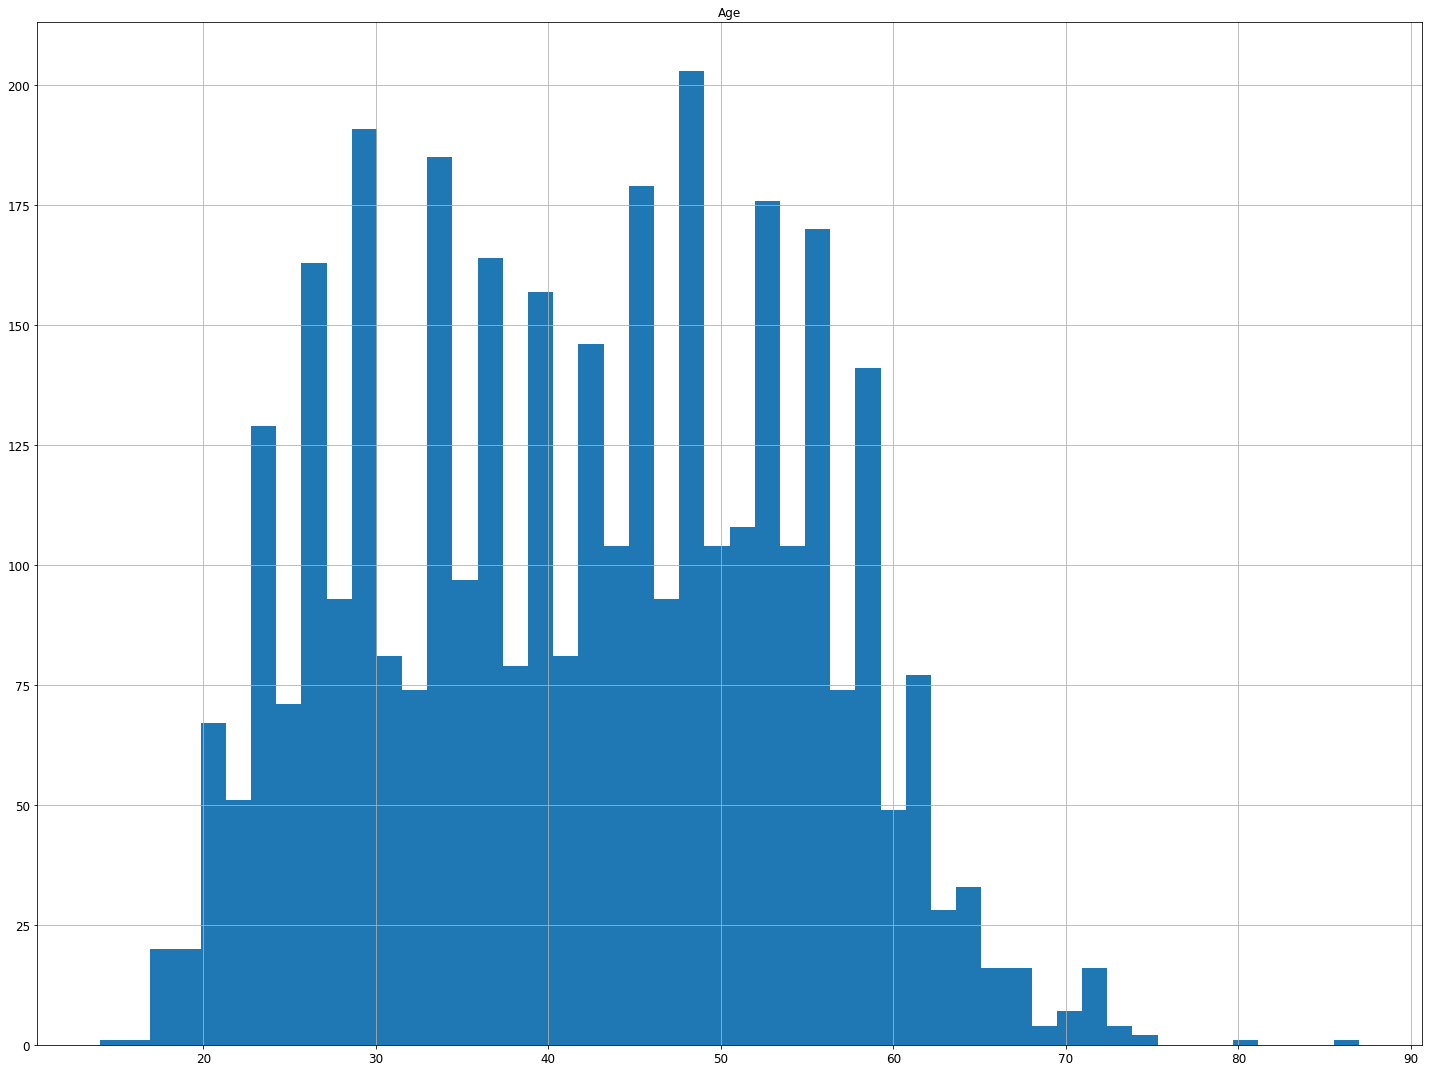

In [360]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
save_fig("age_histogram_plot")
plt.show()

In [315]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [316]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [317]:
train_set, test_set = split_train_test(data, 0.2)
print(len(train_set), "train +", len(test_set), "test")

2867 train + 716 test


In [318]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [319]:
# This version supports both Python 2 and Python 3, instead of just Python 3.
def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [320]:
test_set.head()

,CaseNumber,Date,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,...,Benzodiazepine,Methadone,Amphet,Tramad,Morphine (not heroin),Other,Any Opioid,MannerofDeath,AmendedMannerofDeath,DeathLoc
1407,15-18095,11/12/2015,Male,White,55.0,WATERBURY,CT,NEW HAVEN,WATERBURY,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,Accident,NaN,"WATERBURY, CT\n(41.554261, -73.043069)"
411,14-14611,09/29/2014,Male,White,28.0,NEW BRITAIN,NaN,NaN,NEW BRITAIN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"NEW BRITAIN, CT\n(41.667528, -72.783437)"
802,15-12466,07/31/2015,Female,White,40.0,TORRINGTON,CT,LITCHFIELD,HARTFORD,CT,...,Y,NaN,NaN,NaN,NaN,MORPHINE,Y,Accident,NaN,"HARTFORD, CT\n(41.765775, -72.673356)"
3033,16-3031,11/20/2016,Male,White,48.0,WALLINGFORD,NaN,NEW HAVEN,HARTFORD,NaN,...,Y,Y,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"HARTFORD, CT\n(41.765775, -72.673356)"
1546,14-9762,06/25/2014,Female,White,41.0,MIDDLETOWN,NaN,NaN,MIDDLETOWN,NaN,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"MIDDLETOWN, CT\n(41.544654, -72.651713)"


In [321]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)

In [322]:
test_set.head()

,CaseNumber,Date,Sex,Race,Age,Residence City,Residence State,Residence County,Death City,Death State,...,Benzodiazepine,Methadone,Amphet,Tramad,Morphine (not heroin),Other,Any Opioid,MannerofDeath,AmendedMannerofDeath,DeathLoc
1407,15-18095,11/12/2015,Male,White,55.0,WATERBURY,CT,NEW HAVEN,WATERBURY,CT,...,NaN,NaN,NaN,NaN,NaN,NaN,Y,Accident,NaN,"WATERBURY, CT\n(41.554261, -73.043069)"
411,14-14611,09/29/2014,Male,White,28.0,NEW BRITAIN,NaN,NaN,NEW BRITAIN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"NEW BRITAIN, CT\n(41.667528, -72.783437)"
802,15-12466,07/31/2015,Female,White,40.0,TORRINGTON,CT,LITCHFIELD,HARTFORD,CT,...,Y,NaN,NaN,NaN,NaN,MORPHINE,Y,Accident,NaN,"HARTFORD, CT\n(41.765775, -72.673356)"
3033,16-3031,11/20/2016,Male,White,48.0,WALLINGFORD,NaN,NEW HAVEN,HARTFORD,NaN,...,Y,Y,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"HARTFORD, CT\n(41.765775, -72.673356)"
1546,14-9762,06/25/2014,Female,White,41.0,MIDDLETOWN,NaN,NaN,MIDDLETOWN,NaN,...,Y,NaN,NaN,NaN,NaN,NaN,NaN,Accident,NaN,"MIDDLETOWN, CT\n(41.544654, -72.651713)"


' -73.189476'

In [352]:
data['Age'].describe()

count    3579.000000
mean       42.005029
std        12.338571
min        14.000000
25%        32.000000
50%        43.000000
75%        52.000000
max        87.000000
Name: Age, dtype: float64

In [326]:
data['lat'] = pd.to_numeric(data['lat'], errors='coerce').fillna(0)

data['lon'] = pd.to_numeric(data['lon'], errors='coerce').fillna(0)


In [327]:
data['lat'].describe()

count    3583.000000
mean       41.403000
std         3.820658
min       -72.651713
25%        41.316843
50%        41.554261
75%        41.765775
max        42.025992
Name: lat, dtype: float64

In [328]:
data['lon'].describe()

count    3583.000000
mean      -72.802924
std         0.390928
min       -73.628549
25%       -73.057564
50%       -72.824947
75%       -72.643785
max       -71.808899
Name: lon, dtype: float64

In [340]:
data = data[data['lat'] != data['lat'].min()]

# Discover and visualize the data to gain insights

In [341]:
data['lat'].describe()

count    3579.000000
mean       41.530471
std         0.234003
min        41.026526
25%        41.316843
50%        41.554261
75%        41.765775
max        42.025992
Name: lat, dtype: float64

Saving figure bad_visualization_plot


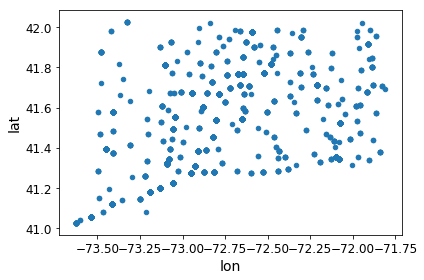

In [342]:
data.plot(kind="scatter", x="lon", y="lat")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


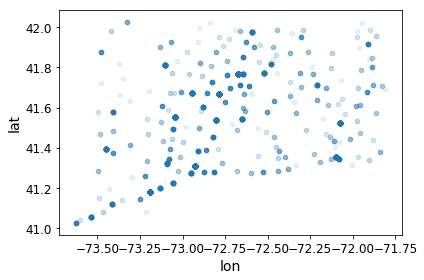

In [343]:
data.plot(kind="scatter", x="lon", y="lat", alpha=0.1)
save_fig("better_visualization_plot")

The argument `sharex=False` fixes a display bug (the x-axis values and legend were not displayed). This is a temporary fix (see: https://github.com/pandas-dev/pandas/issues/10611). Thanks to Wilmer Arellano for pointing it out.

Saving figure housing_prices_scatterplot


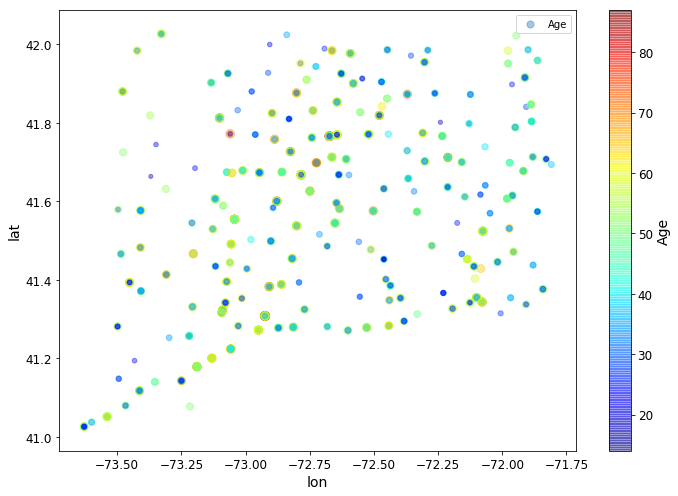

In [349]:
data.plot(kind="scatter", x="lon", y="lat", alpha=0.4,
    s=data["Age"], label="Age", figsize=(10,7),
    c="Age", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

In [ ]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [ ]:
corr_matrix = housing.corr()

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

Note: there was a bug in the previous cell, in the definition of the `rooms_per_household` attribute. This explains why the correlation value below differs slightly from the value in the book (unless you are reading the latest version).

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [ ]:
housing.describe()

# Prepare the data for Machine Learning algorithms

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [ ]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

In [ ]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

In [ ]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

In [ ]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

In [ ]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [ ]:
housing_num = housing.drop('ocean_proximity', axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [ ]:
imputer.fit(housing_num)

In [ ]:
imputer.statistics_

Check that this is the same as manually computing the median of each attribute:

In [ ]:
housing_num.median().values

Transform the training set:

In [ ]:
X = imputer.transform(housing_num)

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [ ]:
housing_tr.loc[sample_incomplete_rows.index.values]

In [ ]:
imputer.strategy

In [ ]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

Now let's preprocess the categorical input feature, `ocean_proximity`:

In [ ]:
housing_cat = housing['ocean_proximity']
housing_cat.head(10)

We can use Pandas' `factorize()` method to convert this string categorical feature to an integer categorical feature, which will be easier for Machine Learning algorithms to handle:

In [ ]:
housing_cat_encoded, housing_categories = housing_cat.factorize()
housing_cat_encoded[:10]

In [ ]:
housing_categories

**Warning**: earlier versions of the book used the `LabelEncoder` class instead of Pandas' `factorize()` method. This was incorrect: indeed, as its name suggests, the `LabelEncoder` class was designed for labels, not for input features. The code worked because we were handling a single categorical input feature, but it would break if you passed multiple categorical input features.

We can convert each categorical value to a one-hot vector using a `OneHotEncoder`:

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

The `OneHotEncoder` returns a sparse array by default, but we can convert it to a dense array if needed:

In [ ]:
housing_cat_1hot.toarray()

**Warning**: earlier versions of the book used the `LabelBinarizer` class at this point. Again, this was incorrect: just like the `LabelEncoder` class, the `LabelBinarizer` class was designed to preprocess labels, not input features. A better solution is to use Scikit-Learn's upcoming `CategoricalEncoder` class: it will soon be added to Scikit-Learn, and in the meantime you can use the code below (copied from [Pull Request #9151](https://github.com/scikit-learn/scikit-learn/pull/9151)).

In [ ]:
# Definition of the CategoricalEncoder class, copied from PR #9151.
# Just run this cell, or copy it to your code, do not try to understand it (yet).

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

The `CategoricalEncoder` expects a 2D array containing one or more categorical input features. We need to reshape `housing_cat` to a 2D array:

In [ ]:
#from sklearn.preprocessing import CategoricalEncoder # in future versions of Scikit-Learn

cat_encoder = CategoricalEncoder()
housing_cat_reshaped = housing_cat.values.reshape(-1, 1)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

The default encoding is one-hot, and it returns a sparse array. You can use `toarray()` to get a dense array:

In [ ]:
housing_cat_1hot.toarray()

Alternatively, you can specify the encoding to be `"onehot-dense"` to get a dense matrix rather than a sparse matrix:

In [ ]:
cat_encoder = CategoricalEncoder(encoding="onehot-dense")
housing_cat_1hot = cat_encoder.fit_transform(housing_cat_reshaped)
housing_cat_1hot

In [ ]:
cat_encoder.categories_

Let's create a custom transformer to add extra attributes:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [ ]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

Now let's build a pipeline for preprocessing the numerical attributes:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [ ]:
housing_num_tr

And a transformer to just select a subset of the Pandas DataFrame columns:

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Now let's join all these components into a big pipeline that will preprocess both the numerical and the categorical features:

In [ ]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('cat_encoder', CategoricalEncoder(encoding="onehot-dense")),
    ])

In [ ]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [ ]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

In [ ]:
housing_prepared.shape

# Select and train a model 

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

In [ ]:
# let's try the full pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Compare against the actual values:

In [ ]:
print("Labels:", list(some_labels))

In [ ]:
some_data_prepared

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

# Fine-tune your model

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

In [ ]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

In [ ]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

In [ ]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

The best hyperparameter combination found:

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_estimator_

Let's look at the score of each hyperparameter combination tested during the grid search:

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
pd.DataFrame(grid_search.cv_results_)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

In [ ]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = cat_pipeline.named_steps["cat_encoder"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

In [ ]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

# Extra material

## A full pipeline with both preparation and prediction

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

## Model persistence using joblib

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## Example SciPy distributions for `RandomizedSearchCV`

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Exercise solutions

## 1.

Question: Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

That's much worse than the `RandomForestRegressor`. Let's check the best hyperparameters found:

In [ ]:
grid_search.best_params_

The linear kernel seems better than the RBF kernel. Notice that the value of `C` is the maximum tested value. When this happens you definitely want to launch the grid search again with higher values for `C` (removing the smallest values), because it is likely that higher values of `C` will be better.

## 2.

Question: Try replacing `GridSearchCV` with `RandomizedSearchCV`.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy-0.19.0/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

The best model achieves the following score (evaluated using 5-fold cross validation):

In [ ]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

Now this is much closer to the performance of the `RandomForestRegressor` (but not quite there yet). Let's check the best hyperparameters found:

In [ ]:
rnd_search.best_params_

This time the search found a good set of hyperparameters for the RBF kernel. Randomized search tends to find better hyperparameters than grid search in the same amount of time.

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.

In [ ]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:

In [ ]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.

## 3.

Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Note: this feature selector assumes that you have already computed the feature importances somehow (for example using a `RandomForestRegressor`). You may be tempted to compute them directly in the `TopFeatureSelector`'s `fit()` method, however this would likely slow down grid/randomized search since the feature importances would have to be computed for every hyperparameter combination (unless you implement some sort of cache).

Let's define the number of top features we want to keep:

In [ ]:
k = 5

Now let's look for the indices of the top k features:

In [ ]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

In [ ]:
np.array(attributes)[top_k_feature_indices]

Let's double check that these are indeed the top k features:

In [ ]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

Looking good... Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [ ]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [ ]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Let's look at the features of the first 3 instances:

In [ ]:
housing_prepared_top_k_features[0:3]

Now let's double check that these are indeed the top k features:

In [ ]:
housing_prepared[0:3, top_k_feature_indices]

Works great!  :)

## 4.

Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [ ]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [ ]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Let's try the full pipeline on a few instances:

In [ ]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Well, the full pipeline seems to work fine. Of course, the predictions are not fantastic: they would be better if we used the best `RandomForestRegressor` that we found earlier, rather than the best `SVR`.

## 5.

Question: Automatically explore some preparation options using `GridSearchCV`.

In [ ]:
param_grid = [
        {'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
         'feature_selection__k': [3, 4, 5, 6, 7]}
]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

In [ ]:
grid_search_prep.best_params_

Great! It seems that we had the right imputer strategy (median), and apparently only the top 7 features are useful (out of 9), the last 2 seem to just add some noise.

In [ ]:
housing.shape

Congratulations! You already know quite a lot about Machine Learning. :)